In [ ]:
#https://github.com/verilylifesciences/variant-annotation/blob/master/interactive/InteractiveVariantAnnotation.ipynb
#https://www.ensembl.org/info/docs/tools/vep/vep_formats.html#input

%%bq query
#standardSQL
  --
  -- Return variants for sample NA12878 that are:
  --   annotated as 'pathogenic' or 'other' in ClinVar
  --   with observed population frequency less than 5%
  --
  WITH sample_variants AS (
  SELECT
    -- Remove the 'chr' prefix from the reference name.
    REGEXP_EXTRACT(reference_name, r'chr(.+)') AS chr,
    start,
    reference_bases,
    alt,
    call.call_set_name
  FROM
    `genomics-public-data.platinum_genomes_deepvariant.single_sample_genome_calls` v,
    v.call call,
    v.alternate_bases alt WITH OFFSET alt_offset
  WHERE
    call_set_name = 'NA12878_ERR194147'
    -- Require that at least one genotype matches this alternate.
    AND EXISTS (SELECT gt FROM UNNEST(call.genotype) gt WHERE gt = alt_offset+1)
    ),
  --
  --
  rare_pathenogenic_variants AS (
  SELECT
    -- ClinVar does not use the 'chr' prefix for reference names.
    reference_name AS chr,
    start,
    reference_bases,
    alt,
    CLNHGVS,
    CLNALLE,
    CLNSRC,
    CLNORIGIN,
    CLNSRCID,
    CLNSIG,
    CLNDSDB,
    CLNDSDBID,
    CLNDBN,
    CLNREVSTAT,
    CLNACC
  FROM
    `bigquery-public-data.human_variant_annotation.ncbi_clinvar_hg38_20170705` v,
    v.alternate_bases alt
  WHERE
    -- Variant Clinical Significance, 0 - Uncertain significance, 1 - not provided,
    -- 2 - Benign, 3 - Likely benign, 4 - Likely pathogenic, 5 - Pathogenic,
    -- 6 - drug response, 7 - histocompatibility, 255 - other
    EXISTS (SELECT sig FROM UNNEST(CLNSIG) sig WHERE REGEXP_CONTAINS(sig, '(4|5|255)'))
    -- TRUE if >5% minor allele frequency in 1+ populations
    AND G5 IS NULL
)
 --
 --
SELECT
  *
FROM
  sample_variants
JOIN
  rare_pathenogenic_variants USING(chr,
    start,
    reference_bases,
    alt)
ORDER BY
  chr,
  start,
  reference_bases,
  alt

In [9]:
from pathlib import Path
home=Path.home()
pathFiles = home / Path('promec/Elite/LARS/2017/april')
fileName='evidence.txt'
trainList=list(pathFiles.rglob(fileName))
print(pathFiles,trainList)

/home/ash022/promec/Elite/LARS/2017/april [PosixPath('/home/ash022/promec/Elite/LARS/2017/april/Andrea/expAsID/evidence.txt'), PosixPath('/home/ash022/promec/Elite/LARS/2017/april/Andrea/glygly/evidence.txt'), PosixPath('/home/ash022/promec/Elite/LARS/2017/april/Andrea/combined/txt/evidence.txt'), PosixPath('/home/ash022/promec/Elite/LARS/2017/april/Andrea/di-methyl/evidence.txt')]


/home/ash022/promec/Elite/LARS/2017/april/Andrea/expAsID/evidence.txt
/home/ash022/promec/Elite/LARS/2017/april/Andrea/glygly/evidence.txt
/home/ash022/promec/Elite/LARS/2017/april/Andrea/combined/txt/evidence.txt
/home/ash022/promec/Elite/LARS/2017/april/Andrea/di-methyl/evidence.txt
24


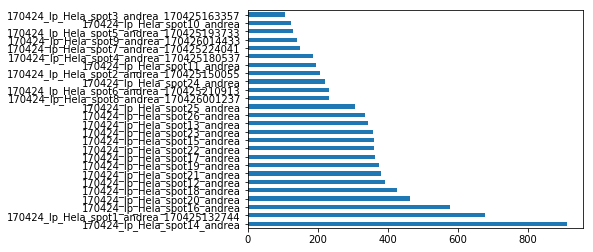

In [10]:
import pandas as pd
df=pd.DataFrame()
for f in trainList:
    peptideHits=pd.read_csv(f,low_memory=False,sep='\t')
    print(f)
    peptideHits['Name']=f
    df=pd.concat([df,peptideHits],sort=False)
#print(df.head(1))
#print(df.columns)
colStrName="Raw file"
print(df.columns.get_loc(colStrName))
dfDP=df.loc[:, df.columns.str.startswith(colStrName)]
dfDP=dfDP[dfDP[colStrName].notnull()]
#dfDP=dfDP.rename(columns = lambda x : str(x)[3:])
dfDPcnt=dfDP[colStrName].value_counts()
dfDPcnt[dfDPcnt>10].plot(kind='barh')

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd

from scipy.optimize import curve_fit as cf
import ipywidgets
ipywidgets.__version__
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def f(x):
    return x
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [3]:
N_samples = 25
x=np.linspace(-2,2,N_samples)

In [4]:
def f(x,a,mu,sigma):
    r=a*np.exp(-(x-mu)**2/(2*sigma**2))
    return (r)

In [5]:
def func(amplitude,ideal_mu,ideal_sigma,noise_sd,noise_mean):
    r=amplitude*np.exp(-(x-ideal_mu)**2/(2*ideal_sigma**2))
    plt.figure(figsize=(8,5))
    plt.plot(x,r,c='k',lw=3)
    r= r+np.random.normal(loc=noise_mean,scale=noise_sd,size=N_samples)
    plt.scatter(x,r,edgecolors='k',c='yellow',s=60)
    plt.grid(True)
    plt.show()
    return (r)

In [6]:
y=interactive(func,amplitude=[1,2,3,4,5],ideal_mu=(-5,5,0.5),
              ideal_sigma=(0,2,0.2),
              noise_sd=(0,1,0.1),noise_mean=(-1,1,0.2))
display(y

interactive(children=(Dropdown(description='amplitude', options=(1, 2, 3, 4, 5), value=1), FloatSlider(value=0…

           Original Params  Estimated Params
Amplitude              0.3          2.097769
Mean                   2.5          1.921346
Std.Dev               -0.8          0.047317


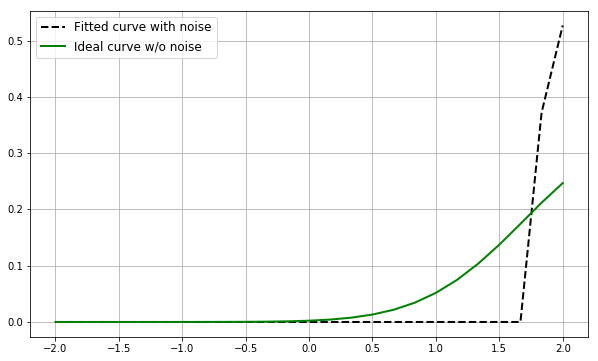

In [48]:
# Curve-fit optimizer
p = y.result
p1,_=cf(f,xdata=x,ydata=p)
par_lst=list(p1)

# Gather ideal parameters from the interactive widget object
p2=list(y.kwargs.values())
p3=p2[0:3]

# Make the data matrix
data = np.array([p3,par_lst])

# Put it in a Data Frame
df=pd.DataFrame(data=data.T,index=['Amplitude','Mean','Std.Dev'],columns=['Original Params','Estimated Params'])
print(df)

# Plot the ideal and estimated curves
plt.figure(figsize=(10,6))
plt.plot(x,f(x,par_lst[0],par_lst[1],par_lst[2]),'k--',lw=2)
plt.plot(x,f(x,p3[0],p3[1],p3[2]),c='green',lw=2)
plt.legend(['Fitted curve with noise','Ideal curve w/o noise'],fontsize=12)
plt.grid(True)
plt.show()

In [42]:
%%perl
$c=0;
while($c<10){$c++;@b=qw/A T G C/;print $b[int(rand(4))]}

CTACGCCTCC

In [43]:
%load_ext rpy2.ipython
#plot(sin(1:100))# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic
# We need ggplot2
%R require(ggplot2)
# Load in the pandas library
import pandas as pd 
# Make a pandas DataFrame
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
# Take the name of input variable df and assign it to an R variable of the same name

df

,A,Alphabet,B,C
0,4,a,0,1
1,3,b,4,2
2,5,c,3,3
3,2,d,6,1
4,1,e,7,2
5,7,f,10,3
6,7,g,11,1
7,5,h,9,2
8,9,i,13,3


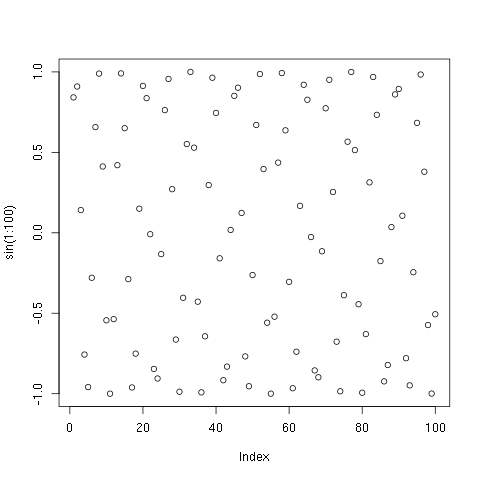

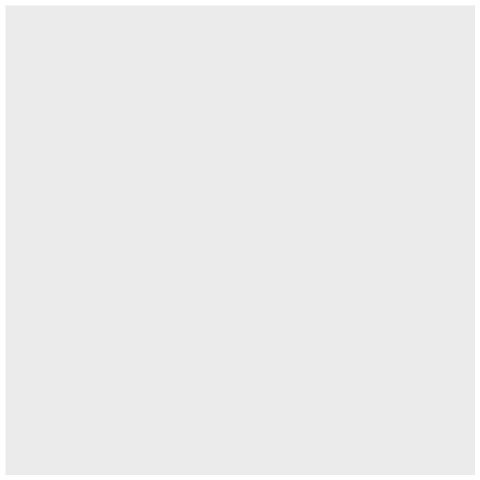

In [54]:
%%R
require(ggplot2)
plot(sin(1:100))
ggplot(x=sin(1:100),y=(1:100))

In [60]:
%%perl
use Statistics::R;
  my $R = Statistics::R->new();
  my $output_file = "file.ps";
  $R->run(qq`postscript("$output_file", horizontal=FALSE, width=500, height=500)`);
  $R->run(q`plot(c(1, 5, 10), type = "l")`);
  $R->run(q`dev.off()`);
  my $input_value = 5;
  $R->set('x', $input_value);
  $R->run(q`y <- x^2`);
  my $output_value = $R->get('y');
  print "y = $output_value\n";
  $R->stop();


y = 25


In [61]:
#https://github.com/bloomberg/bqplot/blob/master/examples/Applications/Outlier%20Detection.ipynb
from scipy.stats import percentileofscore
from scipy.interpolate import interp1d
import bqplot.pyplot as plt
from bqplot import *
from traitlets import List, Float, observe
from ipywidgets import IntRangeSlider, Layout, VBox, HBox, jslink
from pandas import DatetimeIndex
import numpy as np
import pandas as pd

def quantile_space(x, q1=0.1, q2=0.9):
    '''
    Returns a function that squashes quantiles between q1 and q2
    '''
    q1_x, q2_x = np.percentile(x, [q1, q2])
    qs = np.percentile(x, np.linspace(0, 100, 100))
    def get_quantile(t):
        return np.interp(t, qs, np.linspace(0, 100, 100))
    def f(y):
        return np.interp(get_quantile(y), [0, q1, q2, 100], [-1, 0, 0, 1])
    return f

class DNA(VBox):
    
    colors = List()
    q1 = Float()
    q2 = Float()
    
    def __init__(self, data, **kwargs):
        self.data = data
        date_x, date_y = False, False
        transpose = kwargs.pop('transpose', False)
        if transpose is True:
            if type(data.index) is DatetimeIndex:
                self.x_scale = DateScale()
            if type(data.columns) is DatetimeIndex:
                self.y_scale = DateScale()
            x, y = list(data.columns.values), data.index.values
        else:
            if type(data.index) is DatetimeIndex:
                date_x = True
            if type(data.columns) is DatetimeIndex:
                date_y = True
            x, y = data.index.values, list(data.columns.values)
            
        self.q1, self.q2 = kwargs.pop('quantiles', (1, 99))
        
        self.quant_func = quantile_space(self.data.values.flatten(), q1=self.q1, q2=self.q2)
        self.colors = kwargs.pop('colors', ['Red', 'Black', 'Green'])
        
        self.x_scale = DateScale() if date_x is True else LinearScale()
        self.y_scale = DateScale() if date_y is True else OrdinalScale(padding_y=0)
        self.color_scale = ColorScale(colors=self.colors)
        self.heat_map = HeatMap(color=self.quant_func(self.data.T), x=x, y=y, scales={'x': self.x_scale, 'y': self.y_scale,
                                                                               'color': self.color_scale})
        self.x_ax = Axis(scale=self.x_scale)
        self.y_ax = Axis(scale=self.y_scale, orientation='vertical')
        show_axes = kwargs.pop('show_axes', True)
        self.axes = [self.x_ax, self.y_ax] if show_axes is True else []
        
        self.height = kwargs.pop('height', '800px')
        self.layout = kwargs.pop('layout', Layout(width='100%', height=self.height, flex='1'))
        self.fig_margin = kwargs.pop('fig_margin', {'top': 60, 'bottom': 60, 'left': 150, 'right': 0})
        kwargs.setdefault('padding_y', 0.0)
        
        self.create_interaction(**kwargs)
        
        self.figure = Figure(marks=[self.heat_map], axes=self.axes, fig_margin=self.fig_margin, 
                             layout=self.layout, min_aspect_ratio=0.,**kwargs)
        
        super(VBox, self).__init__(children=[self.range_slider, self.figure], layout=Layout(align_items='center',
                                                                                           width='100%',
                                                                                           height='100%'),
                                   **kwargs)
        
    def create_interaction(self, **kwargs):
        self.range_slider = IntRangeSlider(description='Filter Range', value=(self.q1, self.q2), layout=Layout(width='100%'))
        self.range_slider.observe(self.slid_changed, 'value')
        self.observe(self.changed, ['q1', 'q2'])
        
        
    def slid_changed(self, new):
        self.q1 = self.range_slider.value[0]
        self.q2 = self.range_slider.value[1]
        
    def changed(self, new):
        self.range_slider.value = (self.q1, self.q2)
        
        self.quant_func = quantile_space(self.data.values.flatten(), q1=self.q1, q2=self.q2)
        self.heat_map.color = self.quant_func(self.data.T)
        
    def get_filtered_df(self, fill_type='median'):
        q1_x, q2_x = np.percentile(self.data, [self.q1, self.q2])
        if fill_type == 'median':
            return self.data[(self.data >= q1_x) & (self.data <= q2_x)].apply(lambda x: x.fillna(x.median()))
        elif fill_type == 'mean':
            return self.data[(self.data >= q1_x) & (self.data <= q2_x)].apply(lambda x: x.fillna(x.mean()))
        else:
            raise ValueError("fill_type must be one of ('median', 'mean')")

In [62]:
size = 100
def num_to_col_letters(num):
    letters = ''
    while num:
        mod = (num - 1) % 26
        letters += chr(mod + 65)
        num = (num - 1) // 26
    return ''.join(reversed(letters))

letters = []

for i in range(1, size+1):
    letters.append(num_to_col_letters(i))

data = pd.DataFrame(np.random.randn(size, size), columns=letters)

data_dna = DNA(data, title='DNA of our Data', height='1400px', colors=['Red', 'White', 'Green'])
data_dna

DNA(children=(IntRangeSlider(value=(1, 99), description='Filter Range', layout=Layout(width='100%')), Figure(axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=OrdinalScale())], fig_margin={'left': 150, 'top': 60, 'right': 0, 'bottom': 60}, layout=Layout(flex='1', height='1400px', width='100%'), marks=[HeatMap(color=array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02350326,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'color': ColorScale(colors=['Red', 'White', 'Green']), 'y': OrdinalScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'color': {'dimension': 'color'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9}, x=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), y=array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK',
       'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV',
       'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG',
       'BH', 'BI', 'BJ', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR',
       'BS', 'BT', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB', 'CC',
       'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN',
       'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV'],
      dtype='<U2'))], min_aspect_ratio=0.0, padding_y=0.0, scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='DNA of our Data')), layout=Layout(align_items='center', height='100%', width='100%'))

In [63]:
data_dna.q1, data_dna.q2 = 5, 95
data_clean = data_dna.get_filtered_df()
data_mean = data_dna.get_filtered_df(fill_type='mean')
DNA(data_clean, title='Cleaned Data', height='1200px', colors=['Red', 'White', 'Green'])

DNA(children=(IntRangeSlider(value=(1, 99), description='Filter Range', layout=Layout(width='100%')), Figure(axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=OrdinalScale())], fig_margin={'left': 150, 'top': 60, 'right': 0, 'bottom': 60}, layout=Layout(flex='1', height='1200px', width='100%'), marks=[HeatMap(color=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'color': ColorScale(colors=['Red', 'White', 'Green']), 'y': OrdinalScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'color': {'dimension': 'color'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9}, x=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), y=array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK',
       'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV',
       'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG',
       'BH', 'BI', 'BJ', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR',
       'BS', 'BT', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB', 'CC',
       'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN',
       'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV'],
      dtype='<U2'))], min_aspect_ratio=0.0, padding_y=0.0, scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Cleaned Data')), layout=Layout(align_items='center', height='100%', width='100%'))

In [66]:
#https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html?utm_campaign=devshow_series_eagerexecutionfortensorflow_111017&utm_source=gdev&utm_medium=yt-desc
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()


ValueError: tfe.enable_eager_execution has to be called at program startup.

In [67]:
print(tf.__version__)

1.5.0-dev20171213


In [68]:
x = [[2.]]
m = tf.matmul(x, x)
print(m)

tf.Tensor([[ 4.]], shape=(1, 1), dtype=float32)


In [70]:
a = tf.constant(25)
counter = 0
while not tf.equal(a, 1):
  if tf.equal(a % 2, 0):
    a = a / 2
  else:
    a = 3 * a + 1
  print(a)

tf.Tensor(76, shape=(), dtype=int32)
tf.Tensor(38.0, shape=(), dtype=float64)
tf.Tensor(19.0, shape=(), dtype=float64)
tf.Tensor(58.0, shape=(), dtype=float64)
tf.Tensor(29.0, shape=(), dtype=float64)
tf.Tensor(88.0, shape=(), dtype=float64)
tf.Tensor(44.0, shape=(), dtype=float64)
tf.Tensor(22.0, shape=(), dtype=float64)
tf.Tensor(11.0, shape=(), dtype=float64)
tf.Tensor(34.0, shape=(), dtype=float64)
tf.Tensor(17.0, shape=(), dtype=float64)
tf.Tensor(52.0, shape=(), dtype=float64)
tf.Tensor(26.0, shape=(), dtype=float64)
tf.Tensor(13.0, shape=(), dtype=float64)
tf.Tensor(40.0, shape=(), dtype=float64)
tf.Tensor(20.0, shape=(), dtype=float64)
tf.Tensor(10.0, shape=(), dtype=float64)
tf.Tensor(5.0, shape=(), dtype=float64)
tf.Tensor(16.0, shape=(), dtype=float64)
tf.Tensor(8.0, shape=(), dtype=float64)
tf.Tensor(4.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)


In [71]:
def square(x):
  return tf.multiply(x, x)

grad = tfe.gradients_function(square)

print(square(3.))    # [9.]
print(grad(3.))      # [6.]

tf.Tensor(9.0, shape=(), dtype=float32)
[<tf.Tensor: id=780, shape=(), dtype=float32, numpy=6.0>]


In [72]:
gradgrad = tfe.gradients_function(lambda x: grad(x)[0])

print(gradgrad(3.))  # [2.]

[<tf.Tensor: id=796, shape=(), dtype=float32, numpy=2.0>]


In [19]:
def abs(x):
  return x if x > 0. else -x

grad = tfe.gradients_function(abs)

print(grad(2.0))  # [1.]
print(grad(-2.0)) # [-1.]

[<tf.Tensor: id=326, shape=(), dtype=float32, numpy=1.0>]
[<tf.Tensor: id=336, shape=(), dtype=float32, numpy=-1.0>]


In [21]:
def log1pexp(x):
  return tf.log(1 + tf.exp(x))
grad_log1pexp = tfe.gradients_function(log1pexp)

# The gradient computation works fine at x = 0.
print(grad_log1pexp(0.))
# [0.5]
# However it returns a `nan` at x = 100 due to numerical instability.
print(grad_log1pexp(100.))
# [nan]

[<tf.Tensor: id=347, shape=(), dtype=float32, numpy=0.5>]
[<tf.Tensor: id=358, shape=(), dtype=float32, numpy=nan>]


In [22]:
@tfe.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.log(1 + e), grad
grad_log1pexp = tfe.gradients_function(log1pexp)

# Gradient at x = 0 works as before.
print(grad_log1pexp(0.))
# [0.5]
# And now gradient computation at x=100 works as well.
print(grad_log1pexp(100.))
# [1.0]

[<tf.Tensor: id=370, shape=(), dtype=float32, numpy=0.5>]
[<tf.Tensor: id=382, shape=(), dtype=float32, numpy=1.0>]


In [23]:
class MNISTModel(tfe.Network):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.layer1 = self.track_layer(tf.layers.Dense(units=10))
    self.layer2 = self.track_layer(tf.layers.Dense(units=10))
  def call(self, input):
    """Actually runs the model."""
    result = self.layer1(input)
    result = self.layer2(result)
    return result

In [24]:
# Let's make up a blank input image
model = MNISTModel()
batch = tf.zeros([1, 1, 784])
print(batch.shape)
# (1, 1, 784)
result = model(batch)
print(result)
# tf.Tensor([[[ 0.  0., ...., 0.]]], shape=(1, 1, 10), dtype=float32)

(1, 1, 784)
tf.Tensor([[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]], shape=(1, 1, 10), dtype=float32)


In [28]:
def loss_function(model, x, y):
  y_ = model(x)
  return tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_) 

#And then, our training loop:

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
for (x, y) in tfe.Iterator(dataset):
  grads = tfe.implicit_gradients(loss_function)(model, x, y)
  optimizer.apply_gradients(grads)

    #implicit_gradients() 

    #calculates the derivatives of loss_function with respect to all the TensorFlow variables used during its computation.
#We can move computation to a GPU the same way we’ve always done with TensorFlow:
with tf.device("/gpu:0"):
  for (x, y) in tfe.Iterator(dataset):
    optimizer.minimize(lambda: loss_function(model, x, y))

NameError: name 'dataset' is not defined